# QNN on Pynq

This notebook covers how to use low quantized neural networks on Pynq. 
It shows an example of webcam based Cifar-10 recognition using CNV network inspired at VGG-16, featuring 6 convolutional layers, 3 max pool layers and 3 fully connected layers. There are 3 different precision available:

- CNVW1A1 using 1 bit weights and 1 bit activation,
- CNVW1A2 using 1 bit weights and 2 bit activation and
- CNVW2A2 using 2 bit weights and 2 activation

All of them can be performed in pure software and hardware accelerated environment.
In order to reproduce this notebook, you will need an external USB Camera connected to the PYNQ Board.

In [4]:
import bnn

## 1. Load image from the camera

The image is captured from the external USB camera and shown:

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (616) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1280.0 720.0


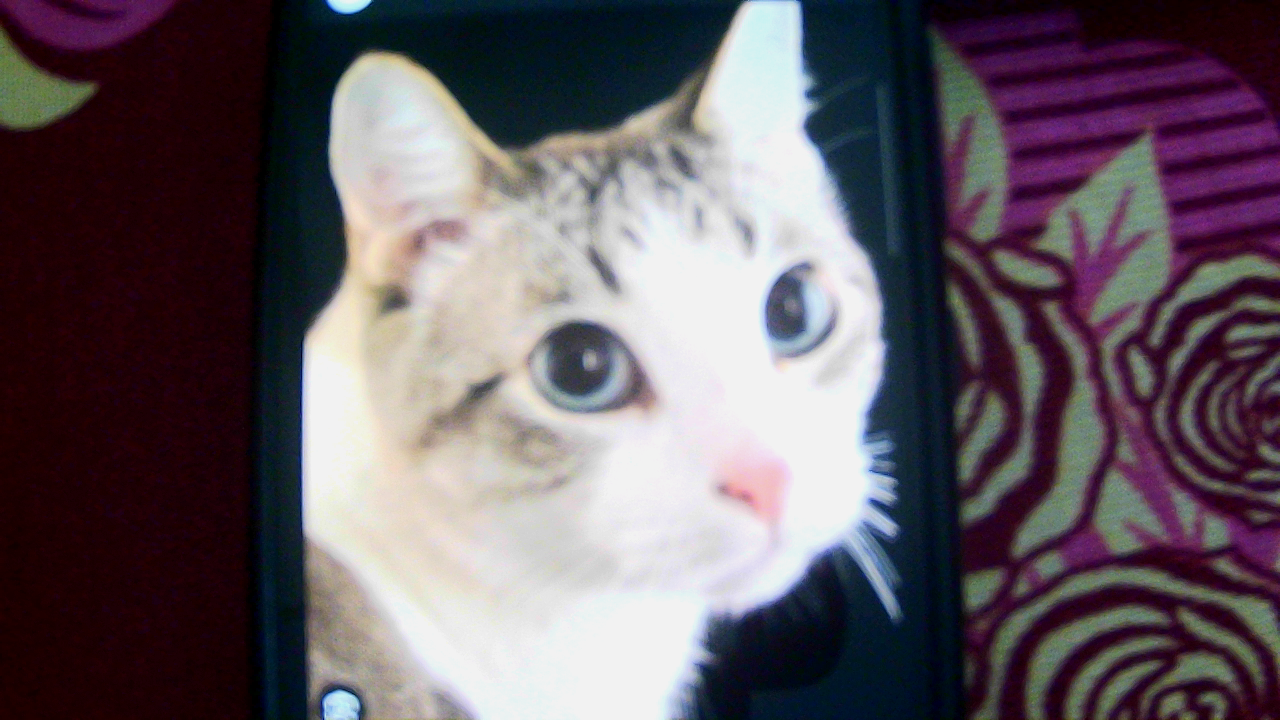

In [5]:
import cv2
from PIL import Image as PIL_Image
from PIL import ImageEnhance
from PIL import ImageOps

# says we capture an image from a webcam
cap = cv2.VideoCapture(0)

# image used for classification, lower pixel
_ , cv2_im_first = cap.read()
cv2_im = cv2.cvtColor(cv2_im_first,cv2.COLOR_BGR2RGB)
img = PIL_Image.fromarray(cv2_im)
print(cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#image used for sobel edge detection, has higher pixel count
cap_sobel = cap
cap_sobel.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap_sobel.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
_ , cv2_im_s = cap_sobel.read()
cv2_im_s = cv2.cvtColor(cv2_im_s,cv2.COLOR_BGR2RGB)
           

# The enhancement values (contrast and brightness) depend on backgroud, external lights etc
bright = ImageEnhance.Brightness(img)                                     
img = bright.enhance(0.95)  

img


## 2. Hardware Inference

The inference can be performed with different precision for weights and activation. Creating a specific Classifier will automatically download the correct bitstream onto PL and load the specified parameters.

### Case 1:

#### W1A1 - 1 bit weights and 1 activation

In [6]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,"cifar10",bnn.RUNTIME_HW)
class_ranksW1A1=hw_classifier.classify_image_details(img)
inferred_class=class_ranksW1A1.argmax()
print("Inferred class: {0}".format(inferred_class))
print("Class name: {0}".format(hw_classifier.class_name(inferred_class)))

Setting network weights and thresholds in accelerator...
Packing and interleaving CIFAR-10 inputs...
Running prebuilt CIFAR-10 test for 1 images...
Inference took 1587 microseconds, 1587 usec per image
Classification rate: 630.12 images per second
Inference took 1587.00 microseconds
Classification rate: 630.12 images per second
Inferred class: 3
Class name: Cat


### Case 2:

#### W1A2 - 1 bit weight and 2 activation

In [7]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A2,"cifar10",bnn.RUNTIME_HW)
class_ranksW1A2=hw_classifier.classify_image_details(img)
inferred_class=class_ranksW1A2.argmax()
print("Inferred class: {0}".format(inferred_class))
print("Class name: {0}".format(hw_classifier.class_name(inferred_class)))

Setting network weights and thresholds in accelerator...
Packing and interleaving CIFAR-10 inputs...
Running prebuilt CIFAR-10 test for 1 images...
Inference took 1629 microseconds, 1629 usec per image
Classification rate: 613.874 images per second
Inference took 1629.00 microseconds
Classification rate: 613.87 images per second
Inferred class: 3
Class name: Cat


### Case 3:

#### W2A2 - 2 bit weights and 2 activation

In [8]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW2A2,"cifar10",bnn.RUNTIME_HW)
class_ranksW2A2=hw_classifier.classify_image_details(img)
inferred_class=class_ranksW2A2.argmax()
print("Inferred class: {0}".format(inferred_class))
print("Class name: {0}".format(hw_classifier.class_name(inferred_class)))

Setting network weights and thresholds in accelerator...
Packing and interleaving CIFAR-10 inputs...
Running prebuilt CIFAR-10 test for 1 images...
Inference took 4868 microseconds, 4868 usec per image
Classification rate: 205.423 images per second
Inference took 4868.00 microseconds
Classification rate: 205.42 images per second
Inferred class: 3
Class name: Cat


## Sobel Edge Detection

In [9]:
import os
from pynq import PL
from pynq import Overlay
from pynq.lib.video import *
import cv2
from pynq import allocate
import matplotlib.pyplot as plt
import numpy as np
import time

In [10]:
# Edit the path to where your .bit and .hwh files are located
ol = Overlay("/home/xilinx/jupyter_notebooks/bnn/base.bit")

In [11]:
vdma_in = ol.axi_vdma_0
vdma_out = ol.axi_vdma_1

In [12]:
sobel_acc = ol.sobel_accel_0

## Image resizing


Image size: 1920x1080 pixels.


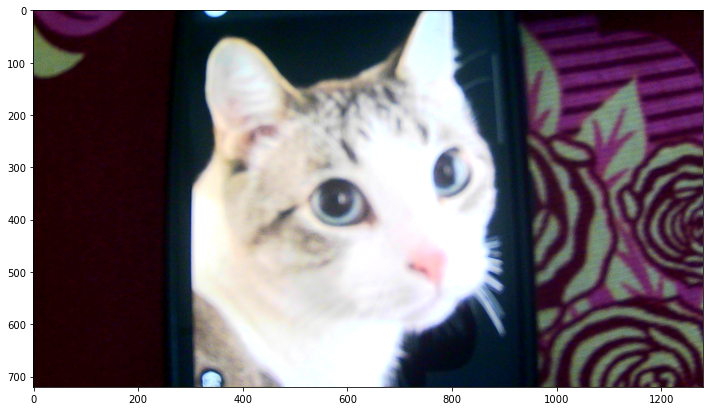

In [14]:
src_rgb = cv2.cvtColor(cv2_im_s, cv2.COLOR_BGR2RGB)
height = 1080
width = 1920
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(cv2_im)

In [15]:
#set the video mode of the DMA before starting
framemode = VideoMode(1920,1080,24)

In [16]:
vdma_in.writechannel.mode = framemode
vdma_out.readchannel.mode = framemode

In [17]:
#read from DRAM and pass to sobel_accel
vdma_in.writechannel.start()
#read from sobel_accel and pass to DRAM
vdma_out.readchannel.start()

In [18]:
# auto restart mode
sobel_acc.write(0x00,0x81)

In [19]:
in_buffer = allocate(shape=(height, width, 3), dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width, 3), dtype=np.uint8, cacheable=1)
resized_src_rgb = cv2.resize(src_rgb, (1920, 1080))
# resized_src_rgb = cv2.resize, (1920, 1080) # Resize to (width, height)
in_buffer[:] = resized_src_rgb
# in_buffer[:] = src_rgb

In [20]:
vdma_in.writechannel.setframe(in_buffer)
out_buffer = vdma_out.readchannel.readframe()

Image size: 1920x1080 pixels.


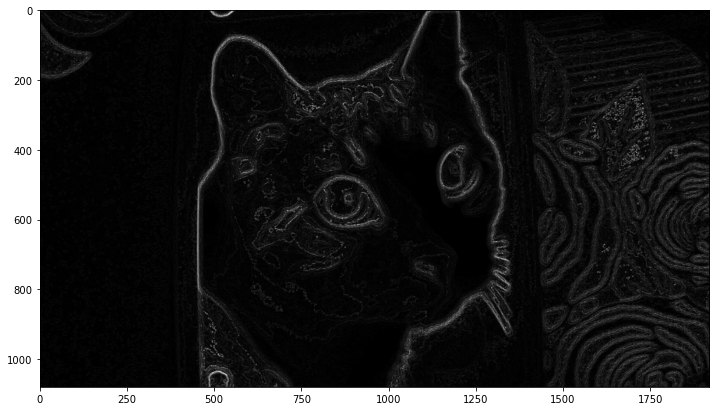

In [21]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(out_buffer)

In [22]:
# Rename the output image of your filter
cv2.imwrite("/home/xilinx/jupyter_notebooks/bnn/Output.PNG",out_buffer)

True

In [23]:
# Reset to Flush Datas
vdma_in.writechannel.reset()
vdma_out.readchannel.reset()
ol.reset()